[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NLTGit/OpenNightLights-colab-mirror/blob/master/onl/tutorials/mod3_3_conditional_operations.ipynb)


# Conditional operations (10 min)

It's sometimes useful to mask individual pixels based on conditional statements which can be applied to these pixels just as with any numerical value. As we are dealing with raster files, it helps to understand that the underlying data structure is similar to a matrix (the pixels represent cells in the matrix).

In this tutorial we'll look at applying some basic conditional operations to an Image and use this to create a mask.

**Our tasks in this exercise:**
1. Create a mask for a VIIRS-DNB Image using a conditional operation
2. Create a map of zones created from chaining a few boolean masks.

## Create a mask for VIIRS-DNB image using a conditional operation

#### First let's initialize a map and get the monthly VIIRS-DNB composite for December 2019 centered on the Catalonia region of Spain

In [1]:
#pip! install geemap seaborn matplotlib

In [2]:
# import geemap and ee for our Python session
import geemap, ee

try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

# get December image, we're using the "avg_rad" band
viirs2019_12 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate("2019-12-01","2019-12-31").select('avg_rad').median()


# center on Catalonia
lat = 41.83
lon = 1.67

# initialize our map
map1 = geemap.Map(center=[lat,lon],zoom=7)
map1.add_basemap('SATELLITE')
map1.addLayer(viirs2019_12.mask(viirs2019_12), {}, "VIIRS-DNB Dec 2019")
map1.addLayerControl()
map1

Map(center=[41.83, 1.67], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(val…

There are a few basic boolean operations that Google Earth Engine includes as built-ins for Images. The output is a binary file that sets a pixel value to 1 if it meets the condition and 0 if it doesnt. Those operations include:

- `lt`: "less than"
- `lte`: "less than or equal to"
- `eq`: "equal to"
- `gt`: "greater than or equal to"
- `gte`: "greater than

The method compares the Image object the method is called on as the left-hand side of the comparison with the value passed as the input argument to the function on the right-hand side. This input can be a scalar value that will be compared to all pixels in the image, or another image that will be used as an element-wise / pixel-wise comparison.

### Let's create a histogram from a region in our scene

This way we can decide on an interesting threshold to set our boolean condition on.

We will discuss what we are doing here in more detail

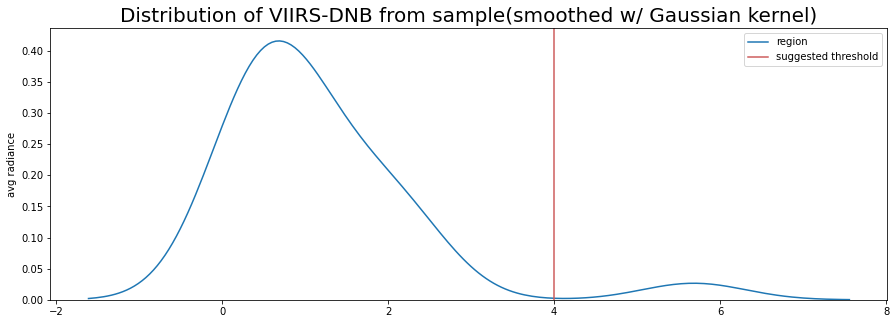

In [3]:
# create a 200 km buffer around the center of Catalonia
aoi = ee.Geometry.Point([lon, lat]).buffer(200000);

# extract a number array from this region
arr = geemap.ee_to_numpy(viirs2019_12, region=aoi)

# create a histogram
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(arr.flatten(), label='region',legend=True, ax=ax)
ax.axvline(4, color='indianred', label='suggested threshold')
plt.legend(fontsize=20)
plt.title('Distribution of VIIRS-DNB from sample(smoothed w/ Gaussian kernel)', fontsize=20);
plt.ylabel('avg radiance')
plt.legend();

Based on our histogram of radiance in the sample region, it might be interesting mask all values that are not greater than or equal to 4.

In [4]:
viirs2019_12_mask = viirs2019_12.gte(4)

# initialize our map
map2 = geemap.Map(center=[lat,lon],zoom=7)
map2.add_basemap('SATELLITE')

# we'll mask the image with itself to keep the visualization clean
map2.addLayer(viirs2019_12_mask.mask(viirs2019_12_mask), {}, "Avg rad >=4")
map2.addLayerControl()
map2

Map(center=[41.83, 1.67], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(val…

By setting our threshold in between the two modes of our distribution, we see that we've created a layer that seems to mask all but the high-intensity light around built-up areas, including Barcelona.

## Create a map of zones based on chained boolean masks


In [5]:
zones = viirs2019_12.gt(1.5).add(viirs2019_12.gt(2)).add(viirs2019_12.gt(5))

# initialize our map
map3 = geemap.Map(center=[lat,lon],zoom=7)
map3.add_basemap('SATELLITE')

map3.addLayer(zones.mask(zones), {'palette':['#cc0909','#e67525','#fff825']}, 'zones')

map3.addLayerControl()
map3

Map(center=[41.83, 1.67], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(val…

Now we can see variation in radiance in a way that sheds "light" (apologies for the pun!) on activity around denser urban areas.

Later in this tutorial, we'll look at calculating the difference in two Images -- and this is a another potential for leveraging conditional operators.

## References:
```{bibliography} ../references.bib
:filter: docname in docnames
```